In [56]:
import pandas as pd
import numpy as np
import math
import re
import datetime

# 固定seed，从而使得训练模型中的随机数相同，可以重现对应的训练结果
np.random.seed(1)

import keras
from sklearn import preprocessing as pro
%matplotlib inline

In [57]:
# 为0的数值被视为有效的sigma门限值，超过该值，将该值替换为mean
sigma_threshold_of_zero=2
# training数据中作为1/K作为vaild数据
K=5

In [58]:
raw_train_datasets = pd.read_excel('train.xlsx')

数据中比较大的问题：
- 有相当的数据有很多的zero，需要确定是否是数值的缺失
  - 部分数据是整列都是0，对于这些数据，这些数据列可以去掉，不参与学习
  - 部分数据列大部分数据都有，少数为0，并且0的不在大概率分布里面，讲0设置为对应的mean
  - 部分数据和其它列完全相同，可以去掉重复的数据列（但是不能跨越不同的工具列）
  - 部分数据的为缺失，此时设置为该列的mean
- 有部分数据有缺失值，需要确定如何处理对应的数据
  - 目前缺失的数据
- 有部分的column的数据是重复的，可以去除对应的数据

In [59]:
def preprocess_train_dataset(df):
    # 去除重复的columns
    df_tmp = df.T.drop_duplicates().T
    print('after duplicates columns removed:{} columns {} row'.format(len(df_tmp.columns),len(df_tmp)))
    # 去除名为Tools的列，因为目前的数据较少，不考虑流水线中不同阶段不同的机器对最终数据的影响。
    df_tmp = df_tmp.filter(regex='^(?!([Tt][Oo][Oo][Ll]))', axis=1)
    print('after machine id columns removed:{} columns {} row'.format(len(df_tmp.columns), len(df_tmp)))
    # 去除ID columns，通过tranpose，index变成了column
    df_tmp.drop(['ID'],axis=1,inplace=True)
    droped_columns = []
    mean_dict = {}
    std_dict = {}
    zero_update_dict = {}
    # 对每一列的数据进行处理
    for col in df_tmp.columns:
        col_tmp = df_tmp[col]
        # 数据中有时间string的数据，格式为%Y%m%d%M%S%f，
        if re.match('^2017[0-9]{10}',str(df_tmp[col].iloc[0])) or re.match('^2017[0-1][0-9][0-3][0-9]',str(df_tmp[col].iloc[0])):
            droped_columns.append(col)
            continue
        # 计算Mean和std的时候忽略为0的元素先
        non_zeros = col_tmp.iloc[col_tmp.nonzero()]
        mean = non_zeros.mean()
        std = non_zeros.std()
        if math.isnan(mean) or std == 0:
            # 只有0和NaN的列求Mean将返回Nan，这种数据没有用，可以直接删除
            droped_columns.append(col)
            continue
        # 0 在 2 sigma之内，那么0为正常值，此时需要重新计算
        if mean - std * sigma_threshold_of_zero < 0  and mean + std * sigma_threshold_of_zero > 0:
            mean = df_tmp[col].mean()
            mean_dict[col] = mean
            std_dict[col] = df_tmp[col].std()
            zero_update_dict[col] = False
            # 使用新计算的Mean替换空值
            df_tmp[col].replace([np.NaN], mean, inplace=True)
        else:
            # 使用mean替换nan和zero值
            df_tmp[col].replace([0,np.NaN], mean, inplace=True)
            mean_dict[col] = mean
            std_dict[col] = std
            zero_update_dict[col] = True
    # 删除Mean为Nan或者标准差为0的数据
    df_tmp.drop(droped_columns,axis=1,inplace=True)
    print('after column data cleaned:{} columns {} rows'.format(len(df_tmp.columns),len(df_tmp)))

    return df_tmp,mean_dict,zero_update_dict,std_dict

In [60]:
# 从已有的文件读取或者重新处理该数据
raw_train_X_pd = raw_train_datasets.drop(labels=['Y'],axis=1)
train_X_pd,mean_dict,zero_update_dict,std_dict = preprocess_train_dataset(raw_train_X_pd)


after duplicates columns removed:3457 columns 500 row
after machine id columns removed:3444 columns 500 row
after column data cleaned:3210 columns 500 rows


In [61]:
# 预处理test数据集
raw_testA = pd.read_excel('testa.xlsx')
raw_testB = pd.read_excel('testb.xlsx')

def process_test_data(test_data, tmp_file=None):
    tmp_df = test_data.copy()
    # 去掉在Trainning data中去除的数据
    tmp_df_columns = tmp_df.columns.tolist()
    train_x_columns = train_X_pd.columns.tolist()
    droped_columns = [x for x in tmp_df_columns if x  not in train_x_columns]
    tmp_df.drop(droped_columns, axis=1,inplace=True)
    extra_columns = []
    # 按照training data中的mean和zero更新到情况处理test data中的zero和NaN
    for col in tmp_df.columns:
        if col not in mean_dict:
            extra_columns.append(col)
            continue
        if zero_update_dict[col]:
            tmp_df[col].replace([0,np.NaN], mean_dict[col], inplace=True)
        else:
            tmp_df[col].replace([np.NaN], mean_dict[col], inplace=True)
    
    # todo:测试数据中依然有数据缺失造成的为0的数据，和正常值有比较大的区别，为了提高预测的准确率，需要对这些数据进行处理。
    # 对每一列的数据进行处理
    for col in tmp_df.columns:
        col_tmp = tmp_df[col]
        # 计算Mean和std的时候忽略为0的元素先
        non_zeros = col_tmp.iloc[col_tmp.nonzero()]
        mean = non_zeros.mean()
        std = non_zeros.std()
        # 0 不在3个标准差内，那么将这些0改为对应的mean值
        if mean + std * 3 < 0  or mean - std * 3 > 0:
            # 使用mean替换zero值
            tmp_df[col].replace([0], mean, inplace=True)
    if tmp_file is not None:
        tmp_df.to_excel(tmp_file)        
    print("test_data with {} columns {} rows cleaned result {} columns {} rows".format(
        len(test_data.columns),len(test_data),len(tmp_df.columns),len(tmp_df)))
    
    return tmp_df 

testA_pd = process_test_data(raw_testA,tmp_file='tmpA.xlsx')
testB_pd = process_test_data(raw_testB,tmp_file='tmpB.xlsx')

test_data with 8028 columns 100 rows cleaned result 3210 columns 100 rows
test_data with 8028 columns 121 rows cleaned result 3210 columns 121 rows


In [62]:
from sklearn.preprocessing import MinMaxScaler

train_Y_whole = raw_train_datasets['Y'].values
train_X_whole = train_X_pd.values
# 因为test数据有异常的数据，尝试合并所有的数据级之后使用nor
all_data = pd.concat([train_X_pd,testA_pd,testB_pd])
# 对数据进行Normalization，保留scaler，用以对test数据Normalization
scaler = MinMaxScaler().fit(all_data.values)
normalized_train_X = scaler.transform(train_X_whole)
index_array = np.arange(normalized_train_X.shape[0])
np.random.shuffle(index_array)
# 对数据进行切割
valid_num = normalized_train_X.shape[0]//K
valid_X = normalized_train_X[index_array[0:valid_num],:];
valid_Y = train_Y_whole[index_array[0:valid_num]]
train_X = normalized_train_X[index_array[valid_num:],:]
train_Y = train_Y_whole[index_array[valid_num:]]
print('valid X shape {} Y shape train X shape {} Y shape {}'.format(valid_X.shape, valid_Y.shape, train_X.shape,train_Y.shape))

# 对测试数据集进行normalization
testA = scaler.transform(testA_pd.values)
testB = scaler.transform(testB_pd.values)
print("testA shape {} testB shape {}".format(testA.shape, testB.shape))

valid X shape (100, 3210) Y shape train X shape (100,) Y shape (400, 3210)
testA shape (100, 3210) testB shape (121, 3210)


In [63]:
from keras import models
from keras import layers
import matplotlib.pyplot as plt
import h5py

# 学习相关的参数
epochs_num=2
batch_size = 32

def show_history(history,model_name):
    acc = history.history['mean_absolute_error']
    val_acc = history.history['val_mean_absolute_error']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo', label='Training mae')
    plt.plot(epochs, val_acc, 'b', label='Validation mae')
    plt.title('{} Training and validation accuracy'.format(model_name))
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss'.format(model_name))
    plt.legend()

    plt.show()

In [68]:
def build_conv1d_model(conv1_k_size=11,conv1_num=32,conv2_k_size=7,conv2_num=16,dense_num=64,pool=2,optimizer='adam',dropout=False,droprate=0.4):
    model = models.Sequential()
    model.add(layers.Conv1D(conv1_num,conv1_k_size,padding='valid',input_shape=(train_X.shape[1],1)))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling1D(pool,padding='valid'))
    if dropout:
        model.add(layers.Dropout(droprate))
    model.add(layers.Conv1D(conv2_num,conv2_k_size,padding='valid'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling1D(pool,padding='valid'))
    if dropout:
        model.add(layers.Dropout(droprate))
    model.add(layers.Flatten())
    model.add(layers.Dense(dense_num))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Dense(1))
    if optimizer is not None:
        model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    else:
        model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

需要同时运行不同的模型，不同的参数，执行一定批次，测试对应的效果，并且执行对应的效果:
1. 初步确认使用

In [89]:
# make models ready
model_array = []

m1 = {}
m1['name'] = 'conv1'
m1['desc'] = 'adam conv1_11x32 conv2_7x16 dense_64 dropout None pool 2'
m1['model'] = build_conv1d_model()
m1['batch_size'] = 32
model_array.append(m1)

m10={}
m10['name'] = 'conv1_bs64'
m10['desc'] = 'adam conv1_11x32 conv2_7x16 dense_64 dropout None pool 2'
m10['model'] = build_conv1d_model()
m10['batch_size'] = 64
model_array.append(m10)

m11={}
m11['name'] = 'conv1_dropout_0.3'
m11['desc'] = 'adam conv1_11x32 conv2_7x16 dense_64 dropout 0.3 pool 2'
m11['model'] = build_conv1d_model(dropout=True, droprate=0.3)
m11['batch_size'] = 32
model_array.append(m11)

m12={}
m12['name'] = 'conv1_dropout_0.6'
m12['desc'] = 'adam conv1_11x32 conv2_7x16 dense_64 dropout 0.6 pool 2'
m12['model'] = build_conv1d_model(dropout=True, droprate=0.6)
m12['batch_size'] = 32
model_array.append(m12)

m2={}
m2['name'] = 'conv2' 
m2['desc'] = 'nadam con1_23x16 conv_11x32 dense_32 dropout None pool 3'
m2['batch_size'] = 32
m2['model'] = build_conv1d_model(
    conv1_k_size = 23, 
    conv1_num=16, 
    conv2_k_size=11,
    conv2_num=32,
    pool=3,
    dense_num=32,
    optimizer='nadam'
)
model_array.append(m2)

m21={}
m21['name'] = 'conv2_dropout_0.3' 
m21['desc'] = 'nadam con1_23x16 conv_11x32 dense_32 dropout dropout 0.3 pool 3'
m21['batch_size'] = 32
m21['model'] = build_conv1d_model(
    conv1_k_size = 23, 
    conv1_num=16, 
    conv2_k_size=11,
    conv2_num=32,
    pool=3,
    dense_num=32,
    optimizer='nadam',
    dropout=True,
    droprate=0.3
)
model_array.append(m21)

m22={}
m22['name'] = 'conv2_dropout_0.6' 
m22['desc'] = 'nadam con1_23x16 conv_11x32 dense_32 dropout dropout 0.6 pool 3'
m22['batch_size'] = 32
m22['model'] = build_conv1d_model(
    conv1_k_size = 23, 
    conv1_num=16, 
    conv2_k_size=11,
    conv2_num=32,
    pool=3,
    dense_num=32,
    optimizer='nadam',
    dropout=True,
    droprate=0.6
)
model_array.append(m22)




## 多个模型并行运行
鉴于模型不是很复杂，计算量不是很大，所以可以多个模型一起并行运行那个，从中间找出性能最好的模型：
- 多个模型增加为数组，一次运行每个模型
- 保存每个模型和模型学习到的weights
- 保存对应的预测结果
- 写入所有模型的对应的性能指标（train/valid的loss和acc）

In [106]:
#使用k_fold CV来改进模型的情况
K=3

index_array = np.arange(normalized_train_X.shape[0])
np.random.shuffle(index_array)
num_per_cv = normalized_train_X.shape[0]//K
cv_X_array = []
cv_Y_array = []

# 使用同一个model训练
cv_models = []
# 生成k_fold CV数组
for index in range(K):
    if index == K - 1:
        cv_X = normalized_train_X[num_per_cv * index:,:]
        cv_Y = train_Y_whole[num_per_cv * index:]
    else:
        cv_X = normalized_train_X[num_per_cv * index:num_per_cv * (index + 1),:]
        cv_Y = train_Y_whole[num_per_cv * index:num_per_cv * (index + 1)]
    cv_X_array.append(cv_X)
    cv_Y_array.append(cv_Y)
for index in range(K+1):
    # 为每个cv创建相同的model，进行训练
    model = build_conv1d_model()
    cv_models.append(model)
print('start to training {}_fold on model'.format(K))
cv_models[0].summary()

testA_X = np.reshape(testA, (testA.shape[0], testB.shape[1], 1))
testB_X = np.reshape(testB, (testB.shape[0], testB.shape[1], 1))
perf = pd.DataFrame()

# 使用k_fold来训练模型
for index in range(K + 1):
    print('training on {}_fold_{}'.format(K, index))
    cv_X_tmp = []
    cv_Y_tmp = []
    if index < K:
        cv_X_tmp = cv_X_array[0:index] + cv_X_array[index+1:]
        cv_train_X = np.concatenate(cv_X_tmp)
        cv_train_X = np.reshape(cv_train_X, (cv_train_X.shape[0],cv_train_X.shape[1],1))
        cv_Y_tmp = cv_Y_array[0:index] + cv_Y_array[index+1:]
        cv_train_Y = np.concatenate(cv_Y_tmp)
        validation_X = np.reshape(cv_X_array[index],(cv_X_array[index].shape[0],cv_X_array[index].shape[1],1))
        validation_data = (validation_X,cv_Y_array[index])
    else:
        # 最后一次使用所有的数据进行训练，不使用validation data
        cv_train_X = np.reshape(normalized_train_X,(normalized_train_X.shape[0], normalized_train_X.shape[1],1))
        cv_train_Y = train_whole_Y
        validation_data = None
    # 开始训练模型
    history = cv_models[index].fit(
        cv_train_X,
        cv_train_Y,
        epochs = epochs_num,
        batch_size = batch_size,
        validation_data = validation_data
    )
    # 保存模型
    json_string = cv_models[index].to_json()
    f = open('cv_model_{}_of_{}_folds.json'.format(index, K),'w')
    f.write(json_string)
    f.close()
    # 保存当前训练的参数
    cv_models[index].save_weights('cv_model_weights_{}_bs_{}.h5'.format(m['name'],m['batch_size']))
    
    # 进行预测，并且保留对应的数据
    testA_Y = cv_models[index].predict(testA_X, batch_size=batch_size)
    testB_Y = cv_models[index].predict(testB_X, batch_size=batch_size)
    # 和trainning的数据进行对比，检查test数据的合理性
    print('{}_fold_{} CV model Train Y min {} max {} mean {} std {}'.format(K,index,np.min(train_Y),np.max(train_Y),np.mean(train_Y),np.std(train_Y)))
    print('{}_fold_{} CV resultA min {} max {} mean {} std {}'.format(K,index,np.min(testA_Y),np.max(testA_Y),np.mean(testA_Y),np.std(testA_Y)))
    print('{}_fold_{} resultB min {} max {} mean {} std {}'.format(K,index,np.min(testB_Y),np.max(testB_Y),np.mean(testB_Y),np.std(testB_Y)))
    # 合并数据结果，并且写入测试结果
    resultA = pd.DataFrame({'ID':raw_testA['ID'].values,'Y':testA_Y.ravel()})
    resultA.to_csv('resultA_{}_fold_{}.csv'.format(K,index), header=False,index=False)
    resultB = pd.DataFrame({'ID':raw_testB['ID'].values,'Y':testB_Y.ravel()})
    resultB.to_csv('resultB_{}_fold_{}.csv'.format(K,index), header=False,index=False)
    if index < K:
        # 去最后10个poch的平均值作为mean来评价本次模型训练的情况
        train_loss_mean = np.mean(history.history['loss'][-11:-1])
        val_loss_mean = np.mean(history.history['loss'][-11:-1])
        train_acc_mean = np.mean(history.history['mean_absolute_error'])
        val_acc_mean = np.mean(history.history['val_mean_absolute_error'])
    else:
        # 最后一次训练没有使用
        train_loss_mean,val_loss_mean,train_acc_mean,val_acc_mean = 0.,0.,0.,0.
    # 保留本次模型运行的结果
    statis = pd.DataFrame(
        [[train_loss_mean, val_loss_mean,train_acc_mean,val_acc_mean,np.min(testA_Y),np.max(testA_Y),np.mean(testA_Y),np.std(testA_Y), \
        np.min(testB_Y),np.max(testB_Y),np.mean(testB_Y),np.std(testB_Y),np.min(train_Y),np.max(train_Y),np.mean(train_Y),np.std(train_Y)]],
        columns=['train_loss','val_loss','train_acc','val_acc','min_testA_Y','max_testA_Y','testA_Y_mean','test_A_std','min_testB_Y','max_testB_Y','testB_Y_mean','test_B_std',\
                 'min_train_Y','max_train_Y','train_Y_mean','train_Y_std'],
        index=['model_{}_fold_{}'.format(K,index)])
    if perf.empty:
        perf = statis
        print('{}_fold_{} CV {}'.format(K,index,statis))
    else:
        perf = pd.concat([perf,statis])
        print('perf {} {}_fold_{} statis later added {}'.format(len(perf), K, index, statis))
    # 将性能信息写入到本地文件
    perf.to_excel('cv_modle_performance_{}_fold.xlsx'.format(K))\
# 平均K_fold的weight，作为我们模型最终的weights
weights = cv_models[K].get_weights()
for index in range(K):
    weights = weights + cv_models[index].get_weights()
weights = weights/(K + 1)
cv_models[K].set_weights(weights)
# 对结果进行预测，作为最终的结果
# 进行预测，并且保留对应的数据
testA_Y = cv_models[K].predict(testA_X, batch_size=batch_size)
testB_Y = cv_models[K].predict(testB_X, batch_size=batch_size)
# 和trainning的数据进行对比，检查test数据的合理性
print('{}_fold_{} CV model Train Y min {} max {} mean {} std {}'.format(K,index,np.min(train_Y),np.max(train_Y),np.mean(train_Y),np.std(train_Y)))
print('{}_fold_{} CV resultA min {} max {} mean {} std {}'.format(K,index,np.min(testA_Y),np.max(testA_Y),np.mean(testA_Y),np.std(testA_Y)))
print('{}_fold_{} resultB min {} max {} mean {} std {}'.format(K,index,np.min(testB_Y),np.max(testB_Y),np.mean(testB_Y),np.std(testB_Y)))
# 合并数据结果，并且写入测试结果
resultA = pd.DataFrame({'ID':raw_testA['ID'].values,'Y':testA_Y.ravel()})
resultA.to_csv('resultA_{}_fold_final.csv'.format(K), header=False,index=False)
resultB = pd.DataFrame({'ID':raw_testB['ID'].values,'Y':testB_Y.ravel()})
resultB.to_csv('resultB_{}_fold_final.csv'.format(K), header=False,index=False)
# 最后一次训练没有使用
train_loss_mean,val_loss_mean,train_acc_mean,val_acc_mean = 0.,0.,0.,0.
# 保留本次模型运行的结果
statis = pd.DataFrame(
    [[train_loss_mean, val_loss_mean,train_acc_mean,val_acc_mean,np.min(testA_Y),np.max(testA_Y),np.mean(testA_Y),np.std(testA_Y), \
    np.min(testB_Y),np.max(testB_Y),np.mean(testB_Y),np.std(testB_Y),np.min(train_Y),np.max(train_Y),np.mean(train_Y),np.std(train_Y)]],
    columns=['train_loss','val_loss','train_acc','val_acc','min_testA_Y','max_testA_Y','testA_Y_mean','test_A_std','min_testB_Y','max_testB_Y','testB_Y_mean','test_B_std',\
             'min_train_Y','max_train_Y','train_Y_mean','train_Y_std'],
    index=['model_{}_{}'.format(m['name'],m['batch_size'])])
if perf.empty:
    perf = statis
    print('{}_fold_final CV {}'.format(K,statis))
else:
    perf = pd.concat([perf,statis])
    print('perf {} {}_fold_final statis later added {}'.format(len(perf), K, statis))


start to training 3_fold on model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_153 (Conv1D)          (None, 3200, 32)          384       
_________________________________________________________________
batch_normalization_229 (Bat (None, 3200, 32)          128       
_________________________________________________________________
activation_229 (Activation)  (None, 3200, 32)          0         
_________________________________________________________________
max_pooling1d_153 (MaxPoolin (None, 1600, 32)          0         
_________________________________________________________________
conv1d_154 (Conv1D)          (None, 1594, 16)          3600      
_________________________________________________________________
batch_normalization_230 (Bat (None, 1594, 16)          64        
_________________________________________________________________
activation_230 (Activation)  (None, 1594, 

NameError: name 'train_whole_Y' is not defined

In [ ]:
train_X = np.reshape(train_X,(train_X.shape[0],train_X.shape[1],1))
valid_X = np.reshape(valid_X,(valid_X.shape[0],valid_X.shape[1],1))
testA_X = np.reshape(testA, (testA.shape[0], testB.shape[1], 1))
testB_X = np.reshape(testB, (testB.shape[0], testB.shape[1],1))
perf = pd.DataFrame()
print('Start train on {} models'.format(len(model_array)))
for m in model_array:
    print('fit in model {}:{} with batch_size {}'.format(m['name'], m['desc'], m['batch_size']))
    m['model'].summary()
    history = m['model'].fit(
        train_X,
        train_Y,
        epochs = epochs_num,
        batch_size = m['batch_size'],
        validation_data=(valid_X,valid_Y)
    )
    # 保存模型
    json_string = m['model'].to_json()
    f = open('model_{}.json'.format(m['name']),'w')
    f.write(json_string)
    f.close()
    # 保存当前训练的参数
    m['model'].save('weights_model_{}_bs_{}.h5'.format(m['name'],m['batch_size']))
    #保存history数据
    
    # 进行预测，并且保留对应的数据
    testA_Y = model.predict(testA_X, batch_size=m['batch_size'])
    testB_Y = model.predict(testB_X, batch_size=m['batch_size'])
    # 和trainning的数据进行对比，检查test数据的合理性
    print('Train Y min {} max {} mean {} std {}'.format(np.min(train_Y),np.max(train_Y),np.mean(train_Y),np.std(train_Y)))
    print('resultA min {} max {} mean {} std {}'.format(np.min(testA_Y),np.max(testA_Y),np.mean(testA_Y),np.std(testA_Y)))
    print('resultB min {} max {} mean {} std {}'.format(np.min(testB_Y),np.max(testB_Y),np.mean(testB_Y),np.std(testB_Y)))
    # 合并数据结果，并且写入测试结果
    resultA = pd.DataFrame({'ID':raw_testA['ID'].values,'Y':testA_Y.ravel()})
    resultA.to_csv('resultA_{}_{}.csv'.format(m['name'],m['batch_size']), header=False,index=False)
    resultB = pd.DataFrame({'ID':raw_testB['ID'].values,'Y':testB_Y.ravel()})
    resultB.to_csv('resultB_{}_{}.csv'.format(m['name'],m['batch_size']), header=False,index=False)
    # 去最后10个poch的平均值作为mean来评价本次模型训练的情况
    train_loss_mean = np.mean(history.history['loss'][-11:-1])
    val_loss_mean = np.mean(history.history['loss'][-11:-1])
    train_acc_mean = np.mean(history.history['mean_absolute_error'])
    val_acc_mean = np.mean(history.history['val_mean_absolute_error'])
    # 保留本次模型运行的结果
    statis = pd.DataFrame(
        [[train_loss_mean, val_loss_mean,train_acc_mean,val_acc_mean,np.min(testA_Y),np.max(testA_Y),np.mean(testA_Y),np.std(testA_Y), \
        np.min(testB_Y),np.max(testB_Y),np.mean(testB_Y),np.std(testB_Y),np.min(train_Y),np.max(train_Y),np.mean(train_Y),np.std(train_Y)]],
        columns=['train_loss','val_loss','train_acc','val_acc','min_testA_Y','max_testA_Y','testA_Y_mean','test_A_std','min_testB_Y','max_testB_Y','testB_Y_mean','test_B_std',\
                 'min_train_Y','max_train_Y','train_Y_mean','train_Y_std'],
        index=['model_{}_{}'.format(m['name'],m['batch_size'])])
    if perf.empty:
        perf = statis
        print('first statis {}'.format(statis))
    else:
        perf = pd.concat([perf,statis])
        print('perf {} statis later added {}'.format(len(perf), statis))
    # 将性能信息写入到本地文件
    perf.to_excel('models_performance.xlsx')




## 处理train data和test data，让两者的数据更为合理
第一步的过程来看，无论是resultA还是resultB中都明显有异常大小的Y值，很明显是对应的testA和testB中的对应数据和train中的数据分布差异造成的。这些差异的来源：
- 所有的数据中都有缺失的数据，在数据中表现为0或者NaN值；
- 数据差异造成的原因在于：
 - 对Train数据的处理方式不对，造成数据偏差，从而让学习到的特征有偏差
 - 部分Test缺失的数据没有被合理地处理，数据本身就有偏差。
- 如何处理这些数据是合理的：
 - 存在一个假设，制造流程中的数据应该是正态分布
 - 使用正态分布来检查数据的合理性，找到可能有问题的地方
 
### [缺失数据的处理](https://www.slideshare.net/QuantUniversity/missing-data-handling)
确实数据的假设，这些假设会决定后续的处理方法
- MCAR：missing complete at random
- MAR：missing at random
- MNAR：missing not at random
在实际的工作中经常有各种原因缺失的数据，对于缺失的数据，主要的做法是：
- 删除对应的数据
 - 删除数据行
 - 删除数据列
 - 仅删除对应的数据pair
- 替换生成对应的数据：根据数据可能的规律假设，生成数据代替缺失的数据
 - Mean
 - Condition Mean
 - Linear Fitting
 - 。。。

### 目前的选择
目前的选择情况如下：
- 数据量很少，并且test数据也缺数据，所以只能采用生成替换数据的方式
- 生成数据是要根据数据的意义以及对应的背景来决定更为合理的方式，这样才有可能不会因为生成数据的不合理带来额外的误差。而在当前环境下并没有对应数据的意义，所以无法依赖这个信息
- 基于上述这点，只能做一个假设，制造业中的数据符合normal distribution，使用mean的方式来生成确实数据
- 同样的使用mean的方式来检查数据的问题，找到其中存在的大问题

使用下面代码来找到normalization之后的数据不太匹配的问题
```python
# 找到array中不超出正态分布的数据以及对应的值
def check_standard_scaled_numpy_array(name,normal_arr,data_df,result_arr):
    '''
    name:被检查的数组的名称
    normal_arr:经过normalized的numpy二维数组
    data_df:data所对对应的pandas.DataFrame
    result_arr:对应数据的Y结果，该结果可以是train数据的实际Y值，也可以是实际的测试
    '''
    abs_arr = np.abs(normal_arr)
    # 检查sigma的值，超出相当的sigma值，说明
    idx_arr = np.argwhere(abs_arr > 1.0)
    for idx in idx_arr:
        print('{} index [{},{}] column {} with value {} normalized value {}  mean {} std {} with Y {}'.format(
            name, idx[0],idx[1], data_df.columns.values[idx[1]], data_df.values[idx[0],idx[1]], normal_arr[idx[0],idx[1]],
            mean_dict[data_df.columns.values[idx[1]]], std_dict[data_df.columns.values[idx[1]]], result_arr[idx[0]]
        ))
    # 检查0变量存在的情况
    id_arr = np.argwhere(abs_arr > 1.0)
    for idx in id_arr:
        if normal_arr[idx[0],idx[1]] == 0:
            print('zeor checking {} index [{},{}] column {} with value {} normalized {} mean {} std {} with Y {}'.format(
            name, idx[0], idx[1], data_df.columns.values[idx[1]], data_df.values[idx[0],idx[1]], normal_arr[idx[0],idx[1]],
            mean_dict[data_df.columns.values[idx[1]]], std_dict[data_df.columns.values[idx[1]]], result_arr[idx[0]]
        ))
                
check_standard_scaled_numpy_array('train_data',normalized_train_X,train_X_pd, train_Y_whole)
check_standard_scaled_numpy_array('testA',testA, testA_pd, testA_Y)
check_standard_scaled_numpy_array('testB',testB, testB_pd, testB_Y)
np.savetxt('testA.csv',testA,delimiter=',')
np.savetxt('testB.csv',testB,delimiter=',')

```
    

## 使用StandardScaler的数据情况
从数据可以看到，很多提供的数据不是正态分布的，极端的情况如下：
testA index 44 column 312X183 with value 4.9 has 1688849860263937.5 sigma mean 3.4000000000000266 std 4.445339663058968e-16 with Y [  3.51291415e+13]
这个的原因是是所有的值都是3.4(500个以上），只有一个值为4.9，std很小导致，导致极端数据的sigma值很大，从而最终预测的时候出现很大的偏差值。这后面有两点：
- 为什么会出现如此异常的数据分布：
 - 数据采集的精度较小导致
 - 部分操作的环节因为环境的因素有了很大的变化，这个也是可能造成生产偏差的问题。
- 处理方法：采用其它的数据normalization方式，比如MinMaxScaler等等
## 使用MinMaxScaler的数据情况
在test数据上依然有异常的数据，导致test的数据预测出现问题：

testB index [30,178] column 210X192 with value 112115.8 normalized value 30301.567567567563  mean 1.4581999999999988 std 0.8153541345510299 with Y [ 1325.29736328]
testB index [30,179] column 210X193 with value 595.17 normalized value 1451.6341463414633  mean 0.0706600000000002 std 0.1181985880305888 with Y [ 1325.29736328]
testB index [30,180] column 210X194 with value 110676.1 normalized value 40990.88888888888  mean 1.8509018036072138 std 0.6486425340081017 with Y [ 1325.29736328]
testB index [30,181] column 210X195 with value 1354.2 normalized value 242.1717352415027  mean 2.849879759519039 std 1.280751217173855 with Y [ 1325.29736328]

此处的原始数据也能反映对应的问题
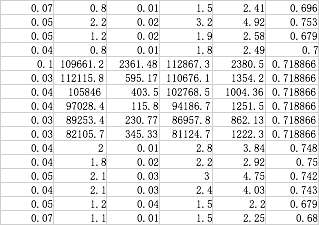
上述部分异常大的数据就是testB中210x192，210x193，210x194的相关数据，这些数据原超其它数据的均值和范围。
如何处理该问题：
- 先不做相关处理，直接提交对应的数据查看loss函数结果。